
#  Adjoint Method for Parameter Estimation in the Lotka–Volterra System

In this notebook, we implement the **adjoint method** to compute the gradient of a cost function with respect to parameters in the Lotka–Volterra predator-prey model and then use the ADAM optimizer for finding model parameter.


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from tqdm import tqdm


##  Upload the Noisy Observations

In [14]:
from google.colab import drive
drive.mount('/content/drive')

# Load it from the same folder
data = np.load('/content/drive/MyDrive/data_exercise_adjoint_ULB.npz')
t_obs = data['t']
s_obs = data['s_noisy'].T

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Info about the time grid
n_t = 1000
t0, tf = 0, 15
times = np.linspace(t0, tf, n_t)       # forward time grid
times_rev = np.flip(times)             # for backward integration

# we will need an interpolator of data.
# Must be global so it's visible in augmented_adjoint_rhs
global s_d_fun
s_d_fun = interp1d(t_obs, s_obs.T, axis=1, kind='linear',
                   bounds_error=False, fill_value="extrapolate")



In [16]:
# This are the functions for the forward pass (STEP 1 of the method)
def lotka_volterra(t, s, a, b, c, d):
    s1, s2 = s
    return [a * s1 - b * s1 * s2, -c * s2 + d * s1 * s2]

def forward_solve(p, s0=np.array([10, 5])):
    a, b, c, d = p

    # Protect against floating point mismatch in t_eval
    sol = solve_ivp(lambda t, s: lotka_volterra(t, s, a, b, c, d),
                    [t0, tf], s0, t_eval=times, method='RK23')
    return sol.y  # shape (2, n_t)


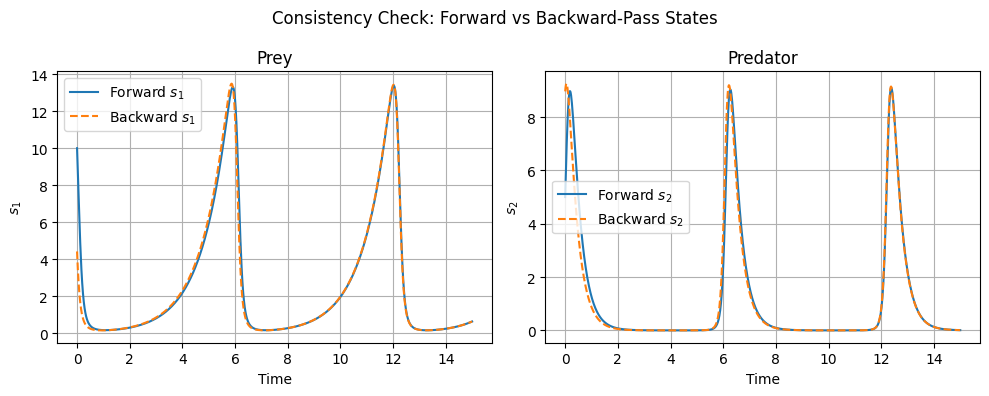

In [17]:
# These are the function for the backward pass (STEP 2 of the method)
# Note that we use an augmented formulation to avoid keeping info from the
# forward pass
def augmented_adjoint_rhs(t, s_lam, p):
    s1, s2, lam1, lam2 = s_lam # assign augmented states
    a, b, c, d = p # parameters
    s1_d, s2_d = s_d_fun(t) # need to interpolate the observation!
    # These are the jacobians for the adjoint problem
    df_ds = np.array([
        [a - b * s2, -b * s1],
        [d * s2, -c + d * s1]
    ])
    dL_ds = 2 * (np.array([s1, s2]) - np.array([s1_d, s2_d]))
    # step forward(backward) for the state variables
    ds1dt = a * s1 - b * s1 * s2
    ds2dt = -c * s2 + d * s1 * s2
    # step forward(backward) for the adjoint variables
    lam = np.array([lam1, lam2])
    dlam_dt = -df_ds.T @ lam - dL_ds
    return np.hstack([ds1dt, ds2dt, dlam_dt])

# given the parameters, give back the states and adjoint states in t\ in[0,T]
def solve_adjoint(p):
    s_traj = forward_solve(p)
    s_T = s_traj[:, -1]
    lam_T = np.zeros(2)
    s_lam_T = np.hstack([s_T, lam_T])
    # backward solve
    sol = solve_ivp(lambda t, y: augmented_adjoint_rhs(t, y, p),
                    [tf, t0], s_lam_T, t_eval=times_rev, method='RK23')
    return sol.y[:, ::-1]  # shape (4, n_t) # this is flipping the solution


# checks: forward and backward integration wors

# Test parameters
p_test = np.array([1.0, 1.0, 3.0, 1.0])

# Forward pass
s_fwd = forward_solve(p_test)  # shape (2, n_t)

# Backward pass (augmented)
sol_aug = solve_adjoint(p_test)  # shape (4, n_t)
s_back = sol_aug[0:2]  # extract state from augmented solution

# Plot comparison

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(times, s_fwd[0], label='Forward $s_1$')
plt.plot(times, s_back[0], '--', label='Backward $s_1$')
plt.xlabel('Time'); plt.ylabel('$s_1$'); plt.title('Prey')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(times, s_fwd[1], label='Forward $s_2$')
plt.plot(times, s_back[1], '--', label='Backward $s_2$')
plt.xlabel('Time'); plt.ylabel('$s_2$'); plt.title('Predator')
plt.legend(); plt.grid(True)

plt.suptitle('Consistency Check: Forward vs Backward-Pass States')
plt.tight_layout()
plt.show()





In [20]:
# Finally here is the cost function for the adjoint method
def cost_and_gradient_adjoint(p, s_obs):
    sol = solve_adjoint(p)
    s1, s2, lam1, lam2 = sol
    J = np.mean((s1 - s_obs[:, 0])**2 + (s2 - s_obs[:, 1])**2)
    grad = np.zeros(4)
    for k in range(n_t):
        df_dp = np.array([
            [s1[k], -s1[k]*s2[k], 0, 0],
            [0, 0, -s2[k], s1[k]*s2[k]]
        ])
        lam = np.array([lam1[k], lam2[k]])
        grad += lam @ df_dp
    grad /= n_t
    return J, grad

# function to evaluate the gradient via finite difference
def finite_difference_gradient(cost_fn, p, epsilon=1e-3):
    grad_fd = np.zeros_like(p)
    for i in range(len(p)):
        p_plus = p.copy()
        p_minus = p.copy()
        p_plus[i] += epsilon
        p_minus[i] -= epsilon
        J_plus, _ = cost_and_gradient_adjoint(p_plus,s_obs)
        J_minus, _ = cost_and_gradient_adjoint(p_minus,s_obs)
        grad_fd[i] = (J_plus - J_minus) / (2 * epsilon)
    return grad_fd


# double check the gradient and compare with finite differences
p_test = np.array([1.2, 1.4, 3.4, 1.2])
J, grad_analytic = cost_and_gradient_adjoint(p_test,s_obs)
grad_fd = finite_difference_gradient(lambda p: cost_and_gradient_adjoint(p,s_obs)[0], p_test)

print("Analytic gradient:     ", grad_analytic)
print("Finite diff gradient:  ", grad_fd)
print("Difference in relative norm (%):       ",
      np.linalg.norm(grad_analytic - grad_fd)/np.linalg.norm(grad_analytic)*100)


Analytic gradient:      [131.50179543 -65.88296834  33.5841085   -8.63751994]
Finite diff gradient:   [132.22553529 -26.85106462  52.1869911  -75.54793996]
Difference in relative norm (%):        52.720456522467096


In [22]:
def adam_optimize(func, x0, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, max_iter=1000, tol=1e-6, **kwargs):
    x = np.array(x0, dtype=np.float64)
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    t = 0  # iteration counter

    history = {
        "costs": [],
        "parameters": []
    }

    for _ in tqdm(range(max_iter), desc="Optimizing with ADAM"):
        t += 1
        J, grad = func(x, **kwargs)
        history["costs"].append(J)
        history["parameters"].append(x.copy())

        # Update biased moment estimates
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * (grad ** 2)

        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        # Update parameters
        x_prev = x
        x = x - lr * m_hat / (np.sqrt(v_hat) + epsilon)

        # Check convergence
        if np.linalg.norm(x - x_prev) < tol:
            return {
                "x": x,
                "final_cost": J,
                "iterations": t,
                "converged": True,
                "history": history
            }

    return {
        "x": x,
        "final_cost": J,
        "iterations": max_iter,
        "converged": False,
        "history": history
    }


In [26]:
# Initial guess (intentionally incorrect)
p0 = np.array([1.2, 1.4, 3.4, 1.2])
result = adam_optimize(cost_and_gradient_adjoint, x0=p0,lr=0.05,max_iter=500,s_obs=s_obs)
print("Estimated parameters:", result["x"])
p_opt = result["x"] # assign the result to p_opt

Optimizing with ADAM: 100%|██████████| 500/500 [01:45<00:00,  4.75it/s]

Estimated parameters: [0.99148888 0.96169272 2.9633319  0.98416699]


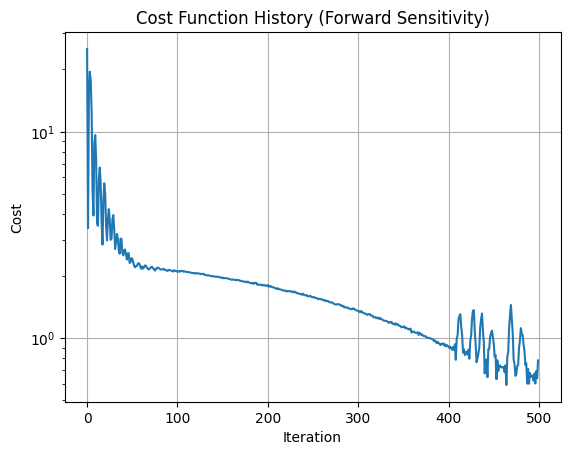

In [27]:
plt.plot(result["history"]["costs"])
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Cost Function History (Forward Sensitivity)")
plt.grid(True)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.show()


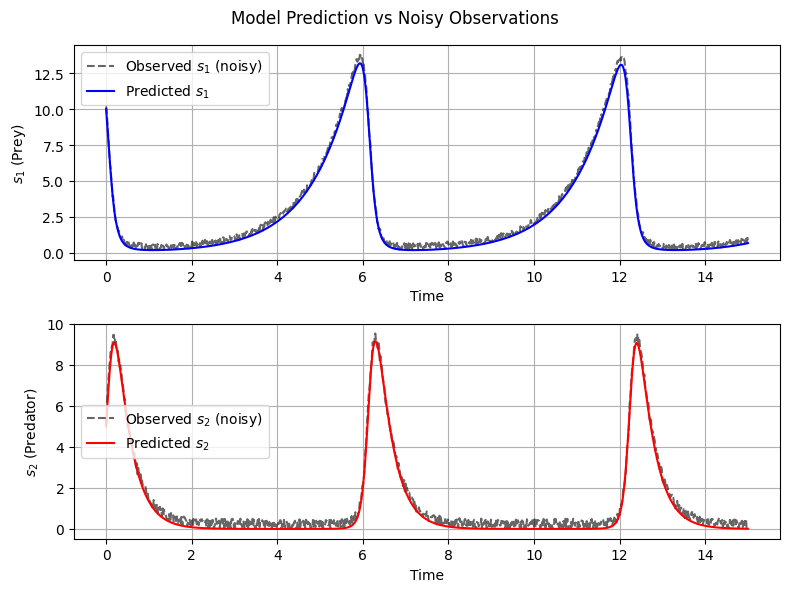

In [31]:
def solve_lotka(p, t_eval=t_obs, s0=s0):
    sol = solve_ivp(lambda t, s: [
        p[0]*s[0] - p[1]*s[0]*s[1],
        -p[2]*s[1] + p[3]*s[0]*s[1]
    ], [t_eval[0], t_eval[-1]], s0, t_eval=t_eval)
    return sol.y.T  # shape (N, 2)

s_pred = solve_lotka(p_opt,s0=[10,5])

# check the truth
#p_true=np.array([1, 1, 3, 1])
#s_pred=solve_lotka(p_true)


# Plot observed (noisy) data and predicted model, one on top of the other
plt.figure(figsize=(8, 6))

# s1 (prey) on top
plt.subplot(2, 1, 1)
plt.plot(t_obs, s_obs[:, 0], 'k--', label='Observed $s_1$ (noisy)', alpha=0.6)
plt.plot(t_obs, s_pred[:, 0], 'b-', label='Predicted $s_1$')
plt.xlabel('Time')
plt.ylabel('$s_1$ (Prey)')
plt.legend()
plt.grid(True)

# s2 (predator) below
plt.subplot(2, 1, 2)
plt.plot(t_obs, s_obs[:, 1], 'k--', label='Observed $s_2$ (noisy)', alpha=0.6)
plt.plot(t_obs, s_pred[:, 1], 'r-', label='Predicted $s_2$')
plt.xlabel('Time')
plt.ylabel('$s_2$ (Predator)')
plt.legend()
plt.grid(True)

plt.suptitle('Model Prediction vs Noisy Observations')
plt.tight_layout()
plt.show()
